In [2]:
import sys; sys.path.append('..'); from wwa import *
cproj = cartopy.crs.PlateCarree()

Xn, Xx, Yn, Yx = [-85,-75,5,15]
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7]    # resized to focus more closely on Gatun catchment

region = "Lake Gatun region (lon "+str(xn)+":"+str(xx)+", lat "+str(yn)+":"+str(yx)+")"

units = {"pr" : "mm/day", "tasmin" : "degC", "tasmax" : "degC"}

Data sources:
- Gridded data from CHIRPS, MSWEP and ERA5Land
- Monthly precipitation data from [Panama Canal Authority stations](https://biogeodb.stri.si.edu/physical_monitoring/research/panamacanalauthority#download), [Barro Colorado](https://biogeodb.stri.si.edu/physical_monitoring/research/barrocolorado) and other stations; 2023 data provided by ACP directly; filled data provided by Robert Stallard
- lake level data from [Panama Canal Authority](https://evtms-rpts.pancanal.com/eng/h2o/index.html) (https://pancanal.com/en/)

---
---
# Observational datasets

## Pre-processing

### CHIRPS

In [ ]:
chirps = xr.open_mfdataset("../../00_WWA_project_folder/live/data/chirps_05/*.nc").sel(longitude = slice(Xn,Xx), latitude = slice(Yn, Yx)).rename("pr", latitude = "lat", longitude = "lon")
chirps.to_netcdf("data/chirps05_panama.nc")

In [14]:
chirps = xr.open_dataset("data/chirps05_panama.nc")

# daily & monthly time series
chirps_ts = chirps.mean(["lat", "lon"])
chirps_ts.to_netcdf("data/chirps_panama_ts.nc")
chirps_ts.resample(time = "MS").sum().to_netcdf("data/pr_monthly_chirps.nc")

# monthly maps
chirps = chirps.resample(time = "MS").sum()
chirps = chirps.where(chirps.sum("time") > 0)
chirps.to_netcdf("data/chirps_panama_monthly.nc")

In [148]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
chirps.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-bci.nc")
chirps.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-gamboa.nc")

In [30]:
# smaller region to check effect of excluding drier region to west of catchment
chirps = xr.open_dataset("data/chirps05_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx)).mean(["lon", "lat"])
chirps = chirps.assign_attrs(region = region)
chirps.resample(time = "MS").sum().to_netcdf("data/pr_monthly_chirps-catchment.nc")

### MSWEP/MSWX

#### Compile

In [ ]:
# cut out yearly slices
for y in range(2024, 1978, -1)[:2]:
    
    new_fnm = "mswep/mswep_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../../00_WWA_project_folder/live/data/mswep_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(precipitation = "pr").to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswep_panama_*.nc").to_netcdf("data/mswep_panama.nc")

In [ ]:
varnm = "tmin"

# cut out yearly slices
for y in range(2024, 1978, -1):
    
    new_fnm = "mswep/mswx_"+varnm+"_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../00_WWA_project_folder/live/data/mswx/"+varnm+"_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(air_temperature = varnm).to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswx_"+varnm+"_panama_*.nc").to_netcdf("data/mswx_"+varnm+"_panama.nc")

#### Extract time series

In [18]:
mswep = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx))
mswep_rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswep.lon, mswep.lat).sum("region")

# land surface only
mswep = mswep.where(mswep_rm == 1)

In [19]:
# daily & monthly time series
mswep_ts = mswep.mean(["lat", "lon"])
mswep_ts.to_netcdf("data/mswep_panama_ts.nc")
mswep_ts.resample(time = "MS").sum().to_netcdf("data/pr_monthly_mswep.nc")

# monthly maps
mswep = mswep.resample(time = "MS").sum()
mswep = mswep.where(mswep.sum("time") > 0)
mswep.to_netcdf("data/mswep_panama_monthly.nc")

In [31]:
# smaller region to check effect of excluding drier region to west of catchment
mswep_sm = mswep.sel(lon = slice(xn,xx), lat = slice(yn, yx)).mean(["lon", "lat"])
mswep_sm = mswep_sm.assign_attrs(region = region)
mswep_sm.to_netcdf("data/pr_monthly_mswep-catchment.nc")

In [50]:
vnm = "tmin"

mswx = xr.open_dataset("data/mswx_"+vnm+"_panama.nc")[vnm].sel(lon = slice(xn,xx), lat = slice(yn, yx))

# land surface only
mswx = mswx.where(mswep_rm == 1)

# daily & monthly time series
mswx_ts = mswx.mean(["lat", "lon"])
mswx_ts.to_netcdf("data/mswx-"+vnm+"_panama_ts.nc")
mswx_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswx-"+vnm+"_ts_monthly.csv")

# monthly maps
mswx = mswx.resample(time = "MS").sum()
mswx = mswx.where(mswx.sum("time") > 0)
mswx.to_netcdf("data/mswx-"+vnm+"_panama_monthly.nc")

In [149]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
mswep.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-bci.nc")
mswep.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-gamboa.nc")

#### Compute PET

In [ ]:
tmin = xr.open_dataset("data/mswx_tmin_panama.nc").tmin
tmax = xr.open_dataset("data/mswx_tmax_panama.nc").tmax

In [ ]:
methods = ["BR65", "HG85", "MB05"]

# compute PET, convert to mm/day, and save for later reference
for mthd in methods:
    pet = potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = mthd)
    pet = convert_units_to(pet, "mm/day", context = "hydro").rename("pet")
    pet = pet.resample(time = "MS").sum()
    pet.to_netcdf("data/pet-"+mthd.lower()+"_mswx_panama_monthly.nc")

In [ ]:
pet = xr.open_dataset("data/pet-hg85_mswx_panama_monthly.nc").pet

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(pet.lon, pet.lat).squeeze(drop = True)

[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).where(rm == 1).mean(["lat", "lon"]).to_netcdf("data/pet_monthly_mswx_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

In [110]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pet_monthly_mswx-bci_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

[None, None, None]

---
### ERA5land

In [7]:
# smaller region to check effect of excluding drier region to west of catchment
era5l = xr.open_dataset("data/era5land_panama_monthly.nc").pr
era5l = era5l.sel(lon = slice(xn,xx), lat = slice(yn, yx), time = slice(None, "2023")).mean(["lon", "lat"])
era5l = era5l.assign_attrs(region = region)
era5l.to_netcdf("data/pr_monthly_era5land-catchment.nc")

In [11]:
era5l.sel(time = slice("1979", "2021")).to_netcdf("data/pr_monthly_era5land-1979-2021-catchment.nc")

In [10]:
era5l = convert_units_to(xr.open_dataset("data/era5land_pev_monthly.nc").pev, "mm")
era5l = era5l * era5l.time.dt.days_in_month / 4

In [31]:
era5l_ts = -era5l.sel(longitude = slice(xn,xx), latitude = slice(yx,yn)).mean(["latitude", "longitude"]).resample(time = "AS-JAN").sum()
era5l_ts.assign_coords(time = era5l_ts.time.dt.year).rename("pet", time = "year").to_dataframe().to_csv("data/annual-oet-era5land.csv")

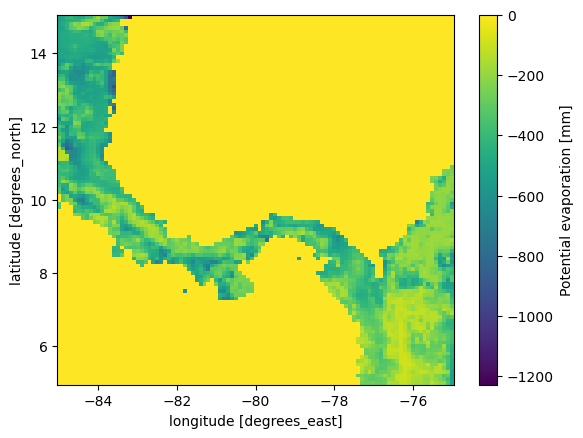

In [21]:
era5l.sel(time = slice("2022-01", "2022-04")).sum("time").plot()

## Extract gridded data for model fitting

In [33]:
ds = "chirps"

# accumulated rainy season precip
da = xr.open_dataset("data/"+ds+"_panama_monthly.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx), time = slice(None, "2023"))

if ds == "era5land": 
    da = da.sel(time = slice("1979", "2021"))
    ds = "era5land-1979-2021"
rs = da.sel(time = [m > 4 for m in da.time.dt.month.values]).resample(time = "AS-JAN").sum()

# flatten & save as .csv for transfer to R
rs = rs.where(rs > 0).assign_coords(time = rs.time.dt.year).rename(time = "year")
rs.mean("year").to_netcdf("data/"+ds+"_pr-rs_tmplt.nc")

# also save the map for easier reconstruction
rs.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas().to_csv("data/"+ds+"_pr-rs_flattened.csv")

## Time series for climate explorer

### Rainy-season precip

In [12]:
for ds in ["chirps", "mswep", "era5land", "era5land-1979-2021"]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+"-catchment.nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))
    extent = ts.region

    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-rs_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds+" wet-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December precipitation in "+extent+" at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### Dry-season precip

In [5]:
for ds in ["chirps", "mswep", "era5land", "era5land-1979-2021"]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+"-catchment.nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))
    extent = ts.region

    ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-ds_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds+" dry-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of January-April precipitation in "+extent+" at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

---
# Climate models


## CORDEX
_Downloaded via synda_

In [ ]:
# remove files that only provide one annoying extra month that makes open_mfdataset fail
! rm wwa/24-03_Panama-drought/cordex/tmp/*20051101*.nc

In [107]:
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/cordex/tmp/"

In [108]:
# filter out any models that don't have both historical & rcp85
model_list = [m for m in sorted(glob.glob(synda_path+"*/*/*/*")) if "CAM-" in m or "SAM- in m"]
mdl_list = {k : list() for k in ["pr", "tasmin", "tasmax"]}
for fp in model_list:
    for varnm in mdl_list.keys():
        fl_hist = glob.glob(fp+"/"+varnm+"/*hist*.nc")
        fl_rcp = glob.glob(fp+"/"+varnm+"/*rcp85*.nc")
        
        if len(fl_hist) == 0 or len(fl_rcp) == 0: continue
        mdl_list[varnm].append(fp)

In [20]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        mdl = "_".join([abridge_gcm[fp.split("/")[-3]]] + fp.split("/")[-2:])
        print(mdl + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        # something wrong with time bounds in this one, can't open the files
        if mdl in ['HadGEM2-ES_r1i1p1_RegCM4-3', 'MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
        
        fl = sorted(glob.glob(fp+"/"+varnm+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
            print(".", end = "")
            new_fnm = out_path+"_".join([varnm, fnm.split("_")[2], mdl, fnm.split("_")[-1]])
            
            # skip if file has already been processed
            if os.path.exists(new_fnm): continue
            
            # load data, convert to correct units
            da = wrap_lon(xr.open_dataset(fnm))[varnm]
            da = convert_units_to(da, units[varnm])
            if "height" in da.coords: da.reset_coords("height", drop = True)  # clean up unwanted extra coordinates
                
            # identify primary coordinates
            if "rlon" in da.dims:
                xdim, ydim = ["rlat", "rlon"]
            elif "x" in da.dims:
                xdim, ydim = ["x", "y"]
            else:
                print(da.dims)
                continue
            
            # cut out smaller region & save as temp file
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
            da = da.sel({xdim : box[xdim], ydim : box[ydim]})
            da.to_netcdf(new_fnm)
            
            print(".", end = "")
        print("")
    clear_output(wait = False)
print("Done.")

### Compile daily data

In [29]:
fl = np.unique(["_".join(fnm.split("_")[:-1]) for fnm in glob.glob("cordex/tmp/pr*.nc")])

In [30]:
for fnm in fl:
    
    if fnm in ['cordex/tmp/pr_SAM-44_MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
    
    ts_fnm = "cordex/ts/"+fnm.split("/")[-1]+".nc"
    
    if not os.path.exists(ts_fnm):
        
        # load data
        da = xr.open_mfdataset(fnm+"*.nc").pr
        
        if any([s == 0 for s in da.shape]): 
            print(fnm+" - no data")
            continue

        # select only box covering panama
        if "rlon" in da.dims:
            xdim, ydim = "rlon", "rlat"
        elif "x" in da.dims:
            xdim, ydim = "x", "y"

        box = np.logical_and(np.logical_and(da.lon >= xn, da.lon <= xx), np.logical_and(da.lat >= yn, da.lat <= yx))
        box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
        panama = da.sel({xdim : box[xdim], ydim : box[ydim]})

        if "time" in panama.lon.dims: panama["lon"] = panama.lon.isel(time = 0, drop = True)
        if "time" in panama.lat.dims: panama["lat"] = panama.lat.isel(time = 0, drop = True)
            
        # select only land cells over panama
        lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(panama.lon, panama.lat)
        panama = panama.where(lsm == 0)

        # get daily mean & save to netcdf
        panama_ts = panama.mean([xdim, ydim])
        panama_ts = panama_ts.assign_attrs(region = region)
        panama_ts.to_netcdf(ts_fnm)
        
print("Done.")

### Compile seasonal patterns

In [82]:
fl = np.unique(["_".join(fnm.split("_")[:-1]) for fnm in glob.glob("cordex/tmp/pr*.nc")])

In [ ]:
for fnm in fl:
    
    if fnm in ['cordex/tmp/pr_SAM-44_MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
    
    sp_fnm = "cordex/sp/"+fnm.split("/")[-1]+"-spatial.nc"
    
    if not os.path.exists(sp_fnm):
        
        # load data
        da = xr.open_mfdataset(fnm+"*.nc").pr.sel(time = slice("1980", "2020"))
        
        if any([s == 0 for s in da.shape]): 
            print(fnm+" - no data")
            continue
            
        rs_pattern = da.sel(time = [m > 4 for m in da.time.dt.month]).mean("time").expand_dims(season = ["wet"])
        ds_pattern = da.sel(time = [m <= 4 for m in da.time.dt.month]).mean("time").expand_dims(season = ["dry"])
        
        xr.concat([rs_pattern, ds_pattern], "season").to_netcdf(sp_fnm)

### Time series for climate explorer

#### Rainy-season precip

In [ ]:
for fnm in glob.glob("cordex/ts/pr_*.nc"):
    
    ds = re.sub(".nc", "", "_".join(fnm.split("_")[1:]))
    ts = xr.open_dataset(fnm).pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))
    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values])
    region = ts.region
        
    ts = ts.resample(time = "AS-JAN").sum()
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "panama_pr-rs_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CORDEX "+ds+" wet-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December precipitation in "+region + " at "+csv_fnm+".dat"
    head = "# year pr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
    clear_output(wait = False)

#### Detrended Nino3.4

In [65]:
for fnm in glob.glob("data/nino34det_cmip5_*.nc"):
    
    mdl = re.sub(".nc", "", "_".join(fnm.split("_")[2:]))
    
    # load model Nino time series & get rainy season mean
    nino = xr.open_dataset(fnm).nino34_det
    nino_rs = nino.rolling(time = 8).mean().groupby("time.month")[12]
        
    # standardise to have mean 0 and sd 1 during observational time period (1979-2023)
    nino_rs = (nino_rs - nino_rs.sel(time = slice("1979", "2023")).mean()) / nino_rs.sel(time = slice("1979", "2023")).std()

    ts = nino_rs.assign_coords(time = nino_rs.time.dt.year).rename(time = "year").to_dataframe()

    csv_fnm = "panama_nino-rs_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP5 "+mdl+" rainy season mean of standardised detrended Nino3.4 index - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# nino3.4 [degC] annual mean of May-December detrended Nino3.4 (standardised wrt 1979-2023) at "+csv_fnm+".dat"
    head = "# year nino"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

---
# Station data

## Panama Canal Authority station locations

In [29]:
# get station datas
acp_stations = pd.read_excel("data/Monthly_Rain_ACP_Vertical.xlsx", sheet_name = "Locations", skiprows = 1)
acp_stations.index = [str(s).strip() for s in acp_stations["STRI Name"]]

# label stations as active/inactive & clean rows
acp_stations["STATUS"] = "Active"
acp_stations.iloc[list(acp_stations["ACP Name"].values).index("Deactivated Stations"):,-1] = "Deactivated"
acp_stations = acp_stations.loc[(~acp_stations["ACP Name"].isna()) & (acp_stations["ACP Name"] != "Deactivated Stations")]

# remove duplicate stations
acp_stations = acp_stations.loc[~((acp_stations.index == "PEDROMIGUEL") & (acp_stations.STATUS == "Deactivated"))]
acp_stations = acp_stations.loc[~((acp_stations.index == "RIOPIEDRAS") & (acp_stations.STATUS == "Deactivated"))]

# remove station with no location data
acp_stations = acp_stations.loc[~((acp_stations.index == "NUEVOSANJUAN") & (acp_stations.STATUS == "Deactivated"))]

# relabel lat & lon
acp_stations = acp_stations.rename(columns = {"LAT (N).1" : "lat", "LONG (W).1" : "lon"})

# fill in missing lat & lon where required
def dms2ll(dms, direction = "N"):
    d,m,s = [float(n) for n in re.split('[°\'"]', dms)[:3]]
    return (float(d) + float(m)/60 + float(s)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

acp_stations.loc["HODGESHILL", "lat"] = dms2ll(acp_stations.loc["HODGESHILL", "LAT (N)"])
acp_stations.loc["HODGESHILL", "lon"] = dms2ll(acp_stations.loc["HODGESHILL", "LONG (W)"], direction = "W")

acp_stations.to_csv("data/acp_stations.csv")

In [3]:
# load data, create headers from first three rows
acp_pr = pd.read_excel("data/Monthly Rain_ACP_Vertical.xlsx", sheet_name = "Rain.All", header = None)
acp_pr.columns = [" ".join([re.sub("nan", "", str(n)) for n in list(r)]).strip() for k, r in acp_pr.iloc[:3].items()]

# clean empty rows
acp_pr = acp_pr.iloc[3:]
acp_pr = acp_pr.loc[~acp_pr.Year.isna()]

# index by date & select columns of interest
acp_pr.index = [datetime.strptime(str(int(r["Year"])) + "-" +str(int(r["Month"])), "%Y-%m") for k,r in acp_pr.iterrows()]
acp_pr = acp_pr[[c for c in acp_pr.columns if not c in ["Year", "Month", "Yr.Mon", "Average", "1-yr", "3-yr", "5-year Running Average"]]]

# modify column names to match station data
acp_pr = acp_pr.rename(columns = {"CAÑO" : "CANO",
                                  "HODGESHILL GOLD HILL" : "GOLD HILL",
                                  "CRISTOBAL COCOSOLO LIMONBAY" : "LIMONBAY",
                                  "MONTELIRIO" : "MONTE LIRIO",
                                  "SAN PEDRO" : "SANPEDRO",
                                  "VALLECENTRALGATUN" : "VALLEGATUN",
                                  "CERROCOCOLI" : "COCOLI",
                                  "PEDROMIGEL" : "PEDROMIGUEL"})

acp_pr.to_csv("data/pr_stations_acp_monthly.csv")

## Use complete years only

- how many stations are left when only mostly-complete stations are considered?
- quite a lot of missing data during the 1960s and 2010s - insisting on completeness at all stations will remove a lot of recent years
- instead of compositing, fit model at each station to complete years only & compare to model fitted to gap-filled 

In [124]:
acp = pd.read_csv("data/pr_stations_acp_monthly.csv", index_col = 0, parse_dates = [0])
acp = acp.loc[acp.index.month > 4]                                                                 # only consider rainy season months

# get wet season accumulation but drop any years with missing months
acp_rs_complete = acp.resample("AS-JAN").sum().where(np.isnan(acp).resample("AS-JAN").sum() == 0)
acp_rs_complete.index = acp_rs_complete.index.year
acp_rs_complete.to_csv("data/acp-complete_pr-rs.csv")

### Identify mostly-complete subsets

In [80]:
# function to pick out stations with > 1month data in more than 90% of years 
acp_nmonths = acp.resample("AS-JAN").count().where(acp.resample("AS-JAN").count() > 0) 

def filter_acp(ys):
    min_years = np.ceil((2023 - ys)*0.98)
    return acp.loc[slice(str(ys),None)].loc[:,acp_nmonths.loc[slice(str(ys),None)].count(axis = 0) > min_years]

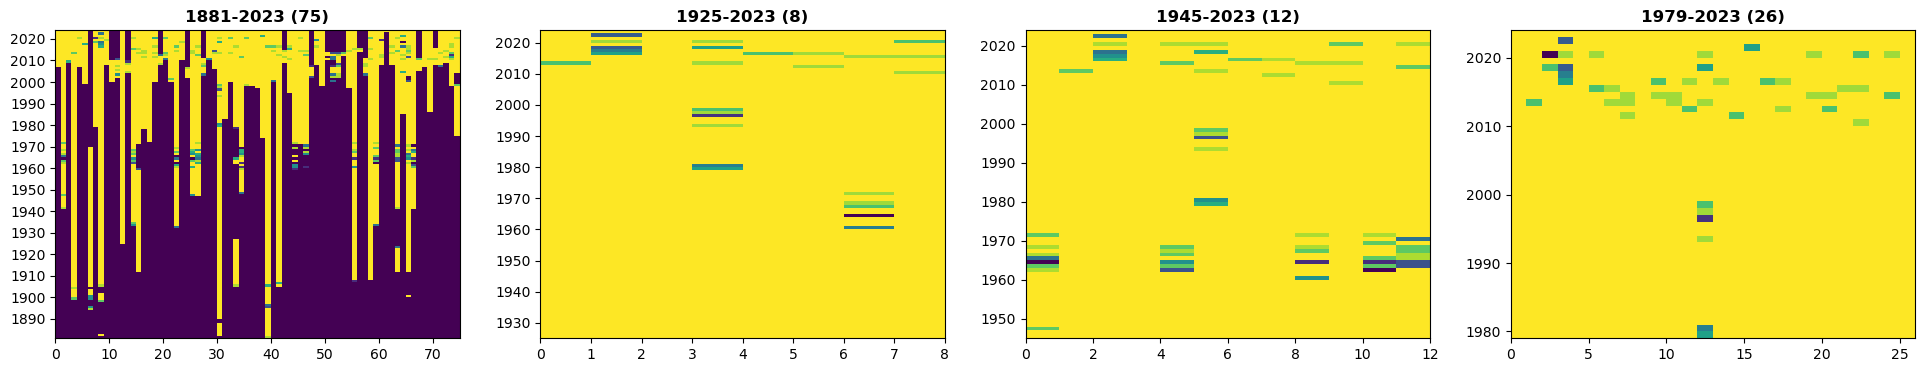

In [125]:
# identify subsets of data to consider
subsets = {"all years" : acp} | {str(ys) : filter_acp(ys) for ys in [1925, 1945, 1979]}

# how many stations are we left with when only mostly-complete stations are considered?
fig, axs = plt.subplots(ncols = 4, figsize = (24,4), dpi = 100)

for i in range(4):
    ax = axs[i]
    ds = list(subsets.keys())[i]
    
    df = (subsets[ds]).resample("AS-JAN").count()

    ax.pcolormesh(df)
    ax.set_title(str(df.index.year.min())+"-"+str(df.index.year.max()) + " ("+str(len(df.columns))+")", fontweight = "bold")
    ax.set_yticks([df.index.year.tolist().index(y) for y in range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10)])
    ax.set_yticklabels(range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10))

## Gap-filled data from Bob Stallard

In [7]:
acp_filled = pd.read_csv("data/acp-filled_monthly-pr.csv", parse_dates = ["Date"], index_col = "Date")

# fix names to match station data
acp_filled = acp_filled.rename(columns = {"CRISTOBAL" : "LIMONBAY",
                                          "MONTELIRIO" : "MONTE LIRIO",
                                          "PEDROMIGEL" : "PEDROMIGUEL"})

# save rainy season precip at all stations
acp_filled_rs = acp_filled.rolling(8).sum().loc[acp_filled.index.month == 12]
acp_filled_rs.index = acp_filled_rs.index.year
acp_filled_rs.to_csv("data/acp-filled_pr-rs.csv")

### Time series for climate explorer

In [17]:
# average over all available stations for now 
ts = acp_filled_rs.mean(axis = 1)

csv_fnm = "panama_pr-rs_acp-filled-allstations"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ACP wet-season precipitation (infilled data) - Panama drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# pr [mm] annual mean of infilled May-December precipitation averaged over all ACP stations at "+csv_fnm+".dat"
head = "# year pr"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

In [19]:
# save shorter time series (easier to loop over files & compare results this way)
for ys in ["1979", "1950", "1925", "1900", "1881"]:
    tmp_fullpath = re.sub(".dat", "-"+ys+".dat", csv_fullpath)
    ! echo "$str1 " > $tmp_fullpath
    ! echo "$str2" >> $tmp_fullpath
    ! echo "$head" >> $tmp_fullpath
    ts.loc[slice(ys,None)].to_csv(tmp_fullpath, sep = " ", mode = "a", header = False)

### Dry-season precip

In [34]:
# save rainy season precip at all stations
acp_filled_ds = acp_filled.rolling(4).sum().loc[acp_filled.index.month == 4]
acp_filled_ds.index = acp_filled_ds.index.year
acp_filled_ds.to_csv("data/acp-filled_pr-ds.csv")

In [35]:
# average over all available stations for now 
ts = acp_filled_ds.mean(axis = 1)

csv_fnm = "panama_pr-ds_acp-filled-allstations"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ACP dry-season precipitation (infilled data) - Panama drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# pr [mm] annual mean of infilled January-April precipitation averaged over all ACP stations at "+csv_fnm+".dat"
head = "# year pr"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

# Other data


## Nino3.4 covariate

In [34]:
# rainy season (May-Dec) Nino3.4
nino_rs = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.rolling(time = 8).mean().groupby("time.month")[12]
ts = nino_rs.assign_coords(time = nino_rs.time.dt.year).rename(time = "year").to_dataframe()

csv_fnm = "panama_nino-rs"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: rainy season mean of detrended Nino3.4 index - Panama drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# nino3.4 [degC] annual mean of May-December detrended Nino3.4 at "+csv_fnm+".dat"
head = "# year nino"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

In [33]:
# rainy season (May-Dec) Nino3.4
nino_ds = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.rolling(time = 4).mean().groupby("time.month")[4]
ts = nino_ds.assign_coords(time = nino_ds.time.dt.year).rename(time = "year").to_dataframe()

csv_fnm = "panama_nino-ds"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: dry season mean of detrended Nino3.4 index - Panama drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# nino3.4 [degC] annual mean of January-April detrended Nino3.4 at "+csv_fnm+".dat"
head = "# year nino"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)